## Homework 8 :  Physics 403, S25
Aidan Meador-Woodruff (ameadorw@ur.rochester.edu)

Due: Friday ?? April, 2025

In [ ]:
# Glorious import statements
import numpy as np
import corner
import emcee
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import optimize as opt
from scipy.optimize import minimize
from scipy.stats import chi2, poisson

### Problem 1 :


---

*a).*

### Problem 2

In [10]:
# Experimental data
z = np.array([0, 6, 12, 18]) * 1e-4  # cm
n = np.array([1880, 940, 530, 305])

# Physical constants
r = 0.52e-4       # cm
delta_rho = 0.063  # g/cm³
g = 980           # cm/s²
T = 290           # K

# Likelihood
def log_likelihood(theta):
    nu0, kB = theta
    if nu0 <= 0 or kB <= 0:
        return -np.inf
    exp_term = np.exp(-4 * np.pi * r**3 * delta_rho * g * z / (3 * kB * T))
    nu = nu0 * exp_term
    return np.sum(poisson.logpmf(n, nu))

# Priors (uniform)
def log_prior(theta):
    nu0, kB = theta
    if 1000 < nu0 < 3000 and 1e-17 < kB < 5e-16:
        return 0.0
    return -np.inf

def log_posterior(theta):
    return log_prior(theta) + log_likelihood(theta)

# Initial walker positions
initial = np.array([2000, 1.38e-16])
ndim, nwalkers, nsteps = 2, 32, 5000
p0 = initial + 1e-4 * initial * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(p0, nsteps, progress=True);

100%|██████████| 5000/5000 [00:03<00:00, 1493.09it/s]


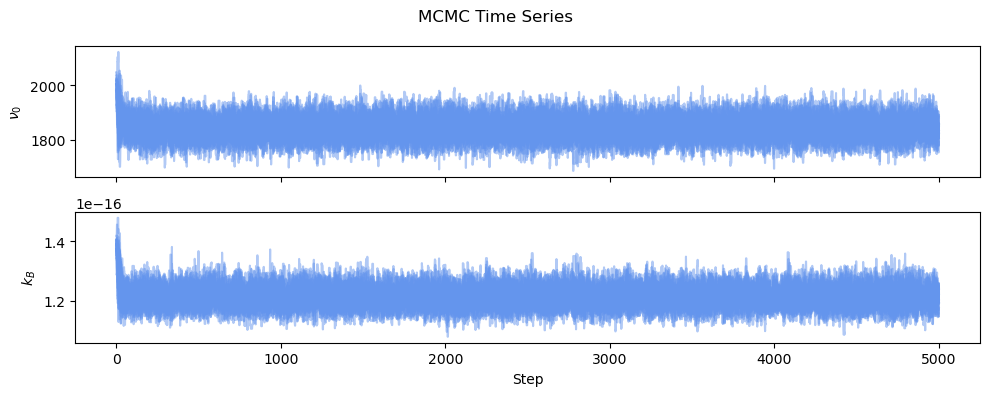

In [4]:

fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
labels = [r"$\nu_0$", r"$k_B$"]
for i in range(ndim):
    axes[i].plot(sampler.get_chain()[:, :, i], alpha=0.5,color='cornflowerblue')
    axes[i].set_ylabel(labels[i])
axes[-1].set_xlabel("Step")
plt.suptitle("MCMC Time Series")
plt.tight_layout()
plt.show()

*b).*

Autocorrelation times: τ_nu0 = 31.8, τ_kB = 32.4
Burn-in: 162 steps, Thinning: every 16 steps


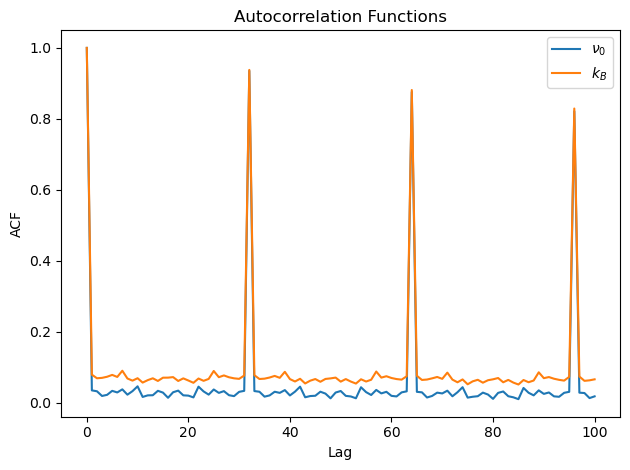

In [7]:
# Autocorrelation time
tau = sampler.get_autocorr_time(tol=0)
burnin = int(5 * np.max(tau))
thin = int(0.5 * np.max(tau))
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)

print(f"Autocorrelation times: τ_nu0 = {tau[0]:.1f}, τ_kB = {tau[1]:.1f}")
print(f"Burn-in: {burnin} steps, Thinning: every {thin} steps")

def autocorr(x, max_lag=100):
    n = len(x)
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full') / np.var(x) / n
    return result[n-1:n+max_lag]

acf_nu0 = autocorr(sampler.get_chain(flat=True)[:, 0])
acf_kB = autocorr(sampler.get_chain(flat=True)[:, 1])

plt.plot(acf_nu0, label=r'$\nu_0$')
plt.plot(acf_kB, label=r'$k_B$')
plt.title("Autocorrelation Functions")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.legend()
plt.tight_layout()
plt.show()


*c).*

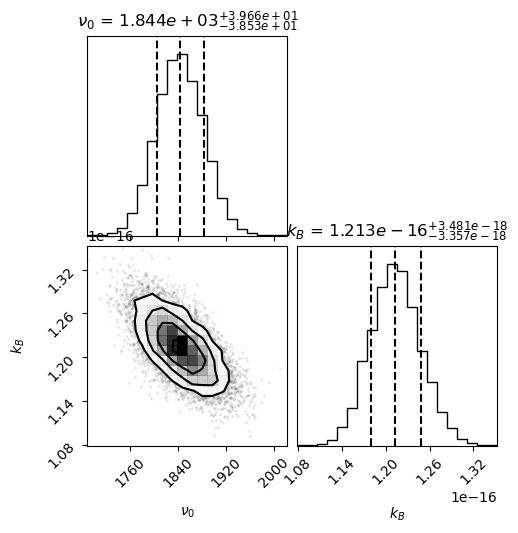

ν₀ = 1.844e+03 (+4.0e+01, -3.9e+01)
k_B = 1.213e-16 (+3.5e-18, -3.4e-18)


In [9]:
fig = corner.corner(flat_samples, labels=[r"$\nu_0$", r"$k_B$"],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True,
                    title_fmt=".3e", title_kwargs={"fontsize": 12})
plt.show()
def summary(samples, name):
    q16, q50, q84 = np.percentile(samples, [16, 50, 84])
    print(f"{name} = {q50:.3e} (+{q84 - q50:.1e}, -{q50 - q16:.1e})")

summary(flat_samples[:, 0], "ν₀")
summary(flat_samples[:, 1], "k_B")



*d).*

N_A = 6.857e+23 (+2.0e+22, -1.9e+22)


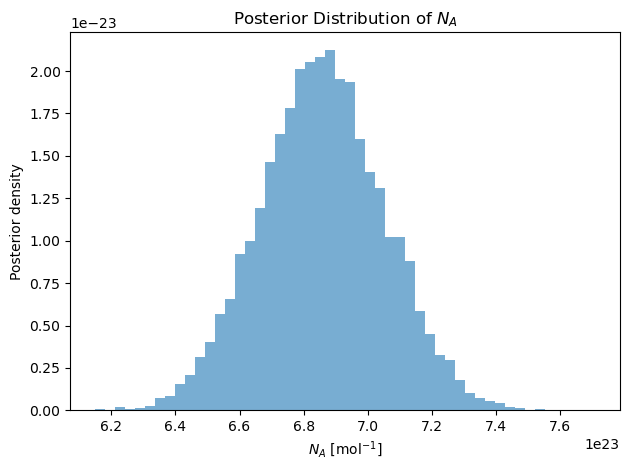

In [11]:
R = 8.32e7  # erg / mol·K
NA_samples = R / flat_samples[:, 1]

summary(NA_samples, "N_A")

plt.hist(NA_samples, bins=50, density=True, alpha=0.6)
plt.xlabel(r"$N_A$ [mol$^{-1}$]")
plt.ylabel("Posterior density")
plt.title("Posterior Distribution of $N_A$")
plt.tight_layout()
plt.show()


*e).*

In [12]:
def log_prior_jeffreys(theta):
    nu0, kB = theta
    if 1000 < nu0 < 3000 and 1e-17 < kB < 5e-16:
        return -np.log(kB)
    return -np.inf

def log_posterior_jeffreys(theta):
    return log_prior_jeffreys(theta) + log_likelihood(theta)

sampler_jeff = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_jeffreys)
sampler_jeff.run_mcmc(p0, nsteps, progress=True)

flat_samples_jeff = sampler_jeff.get_chain(discard=burnin, thin=thin, flat=True)


100%|██████████| 5000/5000 [00:03<00:00, 1423.36it/s]


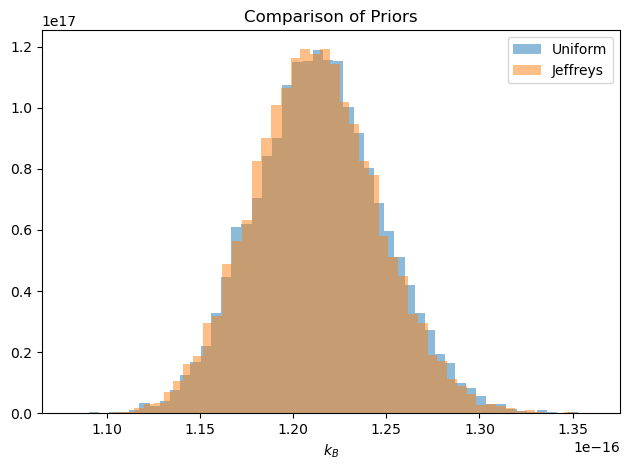

In [13]:
plt.hist(flat_samples[:, 1], bins=50, density=True, alpha=0.5, label="Uniform")
plt.hist(flat_samples_jeff[:, 1], bins=50, density=True, alpha=0.5, label="Jeffreys")
plt.xlabel(r"$k_B$")
plt.title("Comparison of Priors")
plt.legend()
plt.tight_layout()
plt.show()


*f).*

In [14]:
NA_codata = 6.02214076e23
NA_mean = np.mean(NA_samples)
NA_std = np.std(NA_samples)
z_score = abs(NA_mean - NA_codata) / NA_std

print(f"Estimated N_A: {NA_mean:.4e} ± {NA_std:.2e}")
print(f"CODATA N_A:    {NA_codata:.4e}")
print(f"Z-score: {z_score:.2f}")

if z_score < 2:
    print("✅ Not statistically significant (within 2σ)")
else:
    print("⚠️ Statistically significant difference (> 2σ)")


Estimated N_A: 6.8587e+23 ± 1.93e+22
CODATA N_A:    6.0221e+23
Z-score: 4.33
⚠️ Statistically significant difference (> 2σ)
